In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F
import matplotlib as mpl
from typing import Tuple
from PIL import Image

import transforms
import visualize

## Dataset setup

In [2]:
classnames = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}
CLASS_MAX=20

### Transforms

In [3]:
tr_img = transforms.input_transform(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)
tr_target = transforms.target_transform(max_class=transforms.PASCAL_VOC_2012_CLASS_MAX)
tr_img_inv = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

### Dataset loading

In [4]:
dataroot = './data/'

In [5]:
ds_train = torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="train",
    download=False,
    transform=tr_img,
    target_transform=tr_target)


In [6]:
ds_val = torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="val",
    download=False,
    transform=tr_img,
    target_transform=tr_target)

In [7]:
# dataset returns normalized images, we need an inverse op for visualization
inv_normalize = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

In [8]:
len(ds_train)

1464

In [9]:
img, mask = ds_train[2]

In [10]:
img.shape

torch.Size([3, 256, 256])

In [11]:
img.device

device(type='cpu')

In [12]:
mask.shape

torch.Size([256, 256])

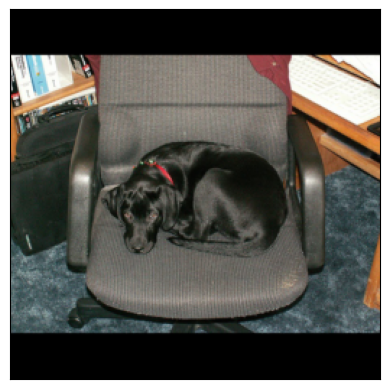

In [13]:
visualize.imshow_tensor(inv_normalize(img))

## Load Model

In [14]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#    in_channels=3, out_channels=CLASS_MAX+1, init_features=32, pretrained=False)

In [16]:
model = torch.load("./dogunet_overfitted.pth")

## Predictions

In [17]:
def topclass_dict(mask: torch.Tensor, k: int=4):
    pred_classes, counts = mask.unique(return_counts=True)
    topcounts, topcounts_idx = torch.topk(counts, k)
    #topclasses = pred_classes[topcounts_idx]

    top_k_classpixels = {
        classnames[pred_classes[i].item()] : counts[i].item()
        for i in topcounts_idx
    }

    return top_k_classpixels

In [18]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor]):
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask.unsqueeze(0)

    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img), prediction=pred_amax, mask=mask)

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)


    return p, top_k_classpixels


### Training Set

(<matplotlib.image.AxesImage at 0x7fcf4d192200>,
 {'background': 48262, 'dog': 6111, 'chair': 6006, 'bicycle': 1215})

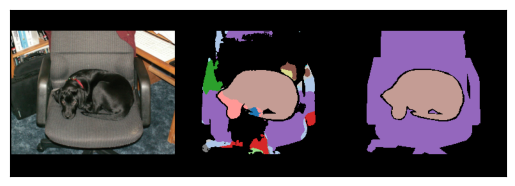

In [19]:
infer_ds_sample(ds_train[2])

(<matplotlib.image.AxesImage at 0x7fcf46ca5660>,
 {'background': 54130, 'diningtable': 2319, 'bottle': 2097, 'person': 1385})

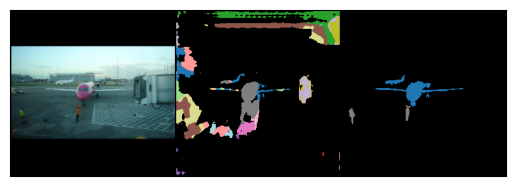

In [20]:
infer_ds_sample(ds_train[0])

### Custom Input

In [21]:
def infer_imgfile(path: str):
    with Image.open(path) as imgfile:
        img = tr_img(imgfile)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred.squeeze(0), dim=0)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img.unsqueeze(0)), prediction=pred_amax.unsqueeze(0))

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)

    return p, top_k_classpixels

{'background': 51524, 'cat': 3387, 'dog': 2765, 'tv/monitor': 1057}

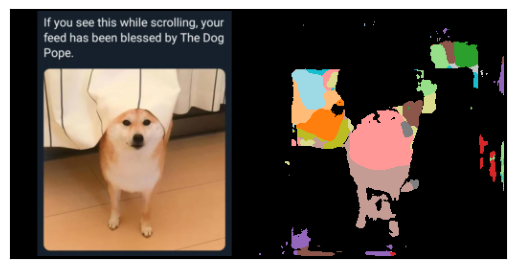

In [22]:
comp_img, classes = infer_imgfile("./data/mysamples/dogpope.jpg")
classes

{'background': 54453, 'person': 5339, 'dog': 1501, 'cow': 1035}

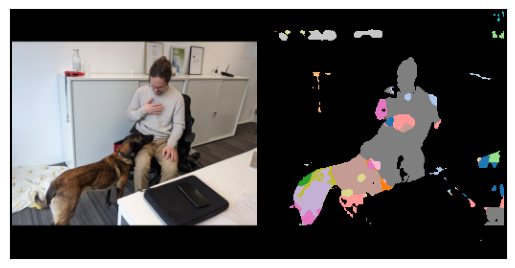

In [23]:
comp_img, classes = infer_imgfile("./data/mysamples/nelly1.jpg")
classes

{'background': 51584, 'person': 2177, 'cat': 2016, 'chair': 1848}

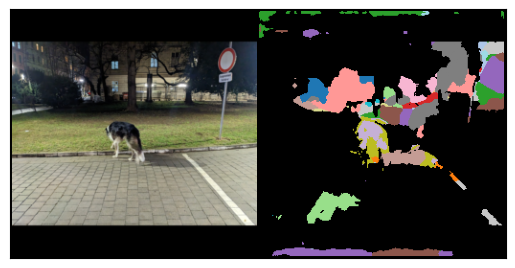

In [24]:
comp_img, classes = infer_imgfile("./data/mysamples/ghost2.jpg")
classes